In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar -xzvf /content/spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

spark-3.2.1-bin-hadoop3.2/
spark-3.2.1-bin-hadoop3.2/LICENSE
spark-3.2.1-bin-hadoop3.2/NOTICE
spark-3.2.1-bin-hadoop3.2/R/
spark-3.2.1-bin-hadoop3.2/R/lib/
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/DESCRIPTION
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/INDEX
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/Rd.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/features.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/hsearch.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/links.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/nsInfo.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/package.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/Meta/vignette.rds
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/NAMESPACE
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/R/
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/R/SparkR
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/R/SparkR.rdb
spark-3.2.1-bin-hadoop3.2/R/lib/SparkR/R/SparkR.rdx
spark-3.2.1-bin-hadoop3.2/R/lib/Sp

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 42 kB/s 
     |████████████████████████████████| 198 kB 45.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=a03567d86b9273df8d98e4bcbd449612ee466bd4bf0eb7754cd0144e182725f1
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
import itertools
from pyspark import SparkContext, SparkConf
from pyspark.sql import *
import re, sys, pickle
from functools import reduce
import pyspark.sql.functions as F
import matplotlib.pyplot as pl

In [ ]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# distance metrics

In [ ]:
def euq(u, v):
    delta = [u[i] - v[i] for i in range(len(u))]
    return reduce(lambda a, b: a + b * b, delta, 0)

def manh(u, v):
    delta = [u[i] - v[i] for i in range(len(u))]
    return reduce(lambda a, b: a + abs(b), delta, 0)


In [ ]:
def findCentroid(pt, cens, distFcn, phi):
    best = float('inf')
    besti = None
    for i, cen in enumerate(cens.value):
        cand = distFcn(pt, cen)
        if cand < best:
            best = cand
            besti = i
    phi += best
    return besti, pt

def aggregate_UV(cumulative, pt):
    cumulative_pt, cumulative_cnt = cumulative
    for i in range(len(pt)):
        cumulative_pt[i] += pt[i]
    return cumulative_pt, cumulative_cnt + 1

def aggregate_UU(a, b):
    a_pt, a_cnt = a
    b_pt, b_cnt = b
    for i in range(len(a_pt)):
        a_pt[i] += b_pt[i]
    return a_pt, a_cnt + b_cnt

# C1 centers with Manhattan metric

In [ ]:
dataFile = 'data.txt'
censFile = 'c1.txt' 
distFcn = manh
outFile = 'Manhattan_c1.txt'

MAX_ITER = 20
k = 10
NDATA = 4601
NDIM = 58
cens = []

with open(censFile) as fh:
    for line in fh:
        if not line:
            continue
        cens.append(list(map(float, line.split())))

cens = sc.broadcast(cens)

data = sc.textFile(dataFile)
data = data.map(lambda l: list(map(float, l.split())))
phi = sc.accumulator(0)
totCosts = []

for it in range(1, MAX_ITER + 1):
    print('\n' * 6 + 'iteration %d' % it + '\n' * 6)

    i_pt = data.map(lambda pt: findCentroid(pt, cens, distFcn, phi))
    
    #calc new centroid
    i_sumCoors_cnt = i_pt.aggregateByKey(([0] * NDIM, 0),
                                         aggregate_UV, aggregate_UU)
    i_sumCoors_cnt = i_sumCoors_cnt.collect()
    newCens = [None] * k
    for i, sumCoors_cnt in i_sumCoors_cnt:
        sumCoors, cnt = sumCoors_cnt
        newCens[i] = [sumCoors[j] / cnt for j in range(len(sumCoors))]
    assert not any([cen is None for cen in newCens])


    totCosts.append(phi.value)
    phi.value = 0
    cens.unpersist()
    cens = sc.broadcast(newCens)

print('\n' * 6 + '%f\n' * MAX_ITER % tuple(totCosts) + '\n' * 6 )
with open(outFile, 'wb') as fh:
    pickle.dump(totCosts, fh)







iteration 1












iteration 2












iteration 3












iteration 4












iteration 5












iteration 6












iteration 7












iteration 8












iteration 9












iteration 10












iteration 11












iteration 12












iteration 13












iteration 14












iteration 15












iteration 16












iteration 17












iteration 18












iteration 19












iteration 20












550117.142000
464869.275879
470897.382277
483914.409173
489216.071003
487629.668550
483711.923214
475330.773493
474871.238846
457232.920115
447494.386197
450915.012577
451250.367073
451974.595540
451570.364070
452739.011366
453082.730287
450583.670860
450368.749317
449011.363726









# C2 centers with Manhattan metric

In [ ]:
dataFile = 'data.txt'
censFile = 'c2.txt' 
distFcn = manh
outFile = 'Manhattan_c2.txt'

MAX_ITER = 20
k = 10
NDATA = 4601
NDIM = 58
cens = []

with open(censFile) as fh:
    for line in fh:
        if not line:
            continue
        cens.append(list(map(float, line.split())))

cens = sc.broadcast(cens)

data = sc.textFile( dataFile)
data = data.map(lambda l: list(map(float, l.split())))
phi = sc.accumulator(0)
totCosts = []

for it in range(1, MAX_ITER + 1):
    print('\n' * 6 + 'iter %d' % it + '\n' * 6)

    i_pt = data.map(lambda pt: findCentroid(pt, cens, distFcn, phi))
    
    i_sumCoors_cnt = i_pt.aggregateByKey(([0] * NDIM, 0),
                                         aggregate_UV, aggregate_UU)
    i_sumCoors_cnt = i_sumCoors_cnt.collect()
    newCens = [None] * k
    for i, sumCoors_cnt in i_sumCoors_cnt:
        sumCoors, cnt = sumCoors_cnt
        newCens[i] = [sumCoors[j] / cnt for j in range(len(sumCoors))]
    assert not any([cen is None for cen in newCens])

    totCosts.append(phi.value)
    phi.value = 0
    cens.unpersist()
    cens = sc.broadcast(newCens)

print('\n' * 6 + '%f\n' * MAX_ITER % tuple(totCosts) + '\n' * 6 )
with open(outFile, 'wb') as fh:
    pickle.dump(totCosts, fh)







iter 1












iter 2












iter 3












iter 4












iter 5












iter 6












iter 7












iter 8












iter 9












iter 10












iter 11












iter 12












iter 13












iter 14












iter 15












iter 16












iter 17












iter 18












iter 19












iter 20












1433739.310000
1084488.776965
973431.714662
895934.592563
865128.335294
845846.647031
827219.582756
803590.345601
756039.517276
717332.902543
694587.925253
684444.501997
674574.747548
667409.469916
663556.627822
660162.777229
656041.322295
653036.754073
651112.426252
649689.013184









# C1 centers with Euclidian metric

In [ ]:
dataFile = 'data.txt'
censFile = 'c1.txt' 
distFcn = euq
outFile = 'Euclidian_c1.txt'

MAX_ITER = 20
k = 10
NDATA = 4601
NDIM = 58
cens = []

with open(censFile) as fh:
    for line in fh:
        if not line:
            continue
        cens.append(list(map(float, line.split())))

cens = sc.broadcast(cens)

data = sc.textFile( dataFile)
data = data.map(lambda l: list(map(float, l.split())))
phi = sc.accumulator(0)
totCosts = []

for it in range(1, MAX_ITER + 1):
    print('\n' * 6 + 'iteration %d' % it + '\n' * 6)

    i_pt = data.map(lambda pt: findCentroid(pt, cens, distFcn, phi))
    
    i_sumCoors_cnt = i_pt.aggregateByKey(([0] * NDIM, 0),
                                         aggregate_UV, aggregate_UU)
    i_sumCoors_cnt = i_sumCoors_cnt.collect()
    newCens = [None] * k
    for i, sumCoors_cnt in i_sumCoors_cnt:
        sumCoors, cnt = sumCoors_cnt
        newCens[i] = [sumCoors[j] / cnt for j in range(len(sumCoors))]
    assert not any([cen is None for cen in newCens])

    totCosts.append(phi.value)
    phi.value = 0
    cens.unpersist()
    cens = sc.broadcast(newCens)

print('\n' * 6 + '%f\n' * MAX_ITER % tuple(totCosts) + '\n' * 6 )
with open(outFile, 'wb') as fh:
    pickle.dump(totCosts, fh)







iteration 1












iteration 2












iteration 3












iteration 4












iteration 5












iteration 6












iteration 7












iteration 8












iteration 9












iteration 10












iteration 11












iteration 12












iteration 13












iteration 14












iteration 15












iteration 16












iteration 17












iteration 18












iteration 19












iteration 20












623660345.306411
509862908.297545
485480681.872008
463997011.685013
460969266.572997
460537847.982768
460313099.653545
460003523.889408
459570539.317735
459021103.342291
458490656.191981
457944232.587975
457558005.198677
457290136.352302
457050555.059563
456892235.615356
456703630.737034
456404203.018975
456177800.541994
455986871.027347









# C2 centers with Euclidian metric

In [ ]:
dataFile = 'data.txt'
censFile = 'c2.txt' 
distFcn = euq
outFile = 'Euclidian_c2.txt'

MAX_ITER = 20
k = 10
NDATA = 4601
NDIM = 58
cens = []

with open(censFile) as fh:
    for line in fh:
        if not line:
            continue
        cens.append(list(map(float, line.split())))

cens = sc.broadcast(cens)

data = sc.textFile( dataFile)
data = data.map(lambda l: list(map(float, l.split())))
phi = sc.accumulator(0)
totCosts = []

for it in range(1, MAX_ITER + 1):
    print('\n' * 6 + 'iteration %d' % it + '\n' * 6)

    i_pt = data.map(lambda pt: findCentroid(pt, cens, distFcn, phi))
    
    i_sumCoors_cnt = i_pt.aggregateByKey(([0] * NDIM, 0),
                                         aggregate_UV, aggregate_UU)
    i_sumCoors_cnt = i_sumCoors_cnt.collect()
    newCens = [None] * k
    for i, sumCoors_cnt in i_sumCoors_cnt:
        sumCoors, cnt = sumCoors_cnt
        newCens[i] = [sumCoors[j] / cnt for j in range(len(sumCoors))]
    assert not any([cen is None for cen in newCens])

    totCosts.append(phi.value)
    phi.value = 0
    cens.unpersist()
    cens = sc.broadcast(newCens)

print('\n' * 6 + '%f\n' * MAX_ITER % tuple(totCosts) + '\n' * 6 )
with open(outFile, 'wb') as fh:
    pickle.dump(totCosts, fh)







iteration 1












iteration 2












iteration 3












iteration 4












iteration 5












iteration 6












iteration 7












iteration 8












iteration 9












iteration 10












iteration 11












iteration 12












iteration 13












iteration 14












iteration 15












iteration 16












iteration 17












iteration 18












iteration 19












iteration 20












438747790.027918
249803933.626003
194494814.406313
169804841.451543
156295748.806276
149094208.108966
142508531.619615
132303869.406530
117170969.837191
108547377.178570
102237203.317996
98278015.749757
95630226.121774
93793314.051193
92377131.968211
91541606.254239
91045573.830425
90752240.101408
90470170.181227
90216416.175631









Euclidian c1 0.2648391714456053
Euclidian c2 0.7669795594605946
Manhattan c1 0.18654709691385904
Manhattan c2 0.515540991023891


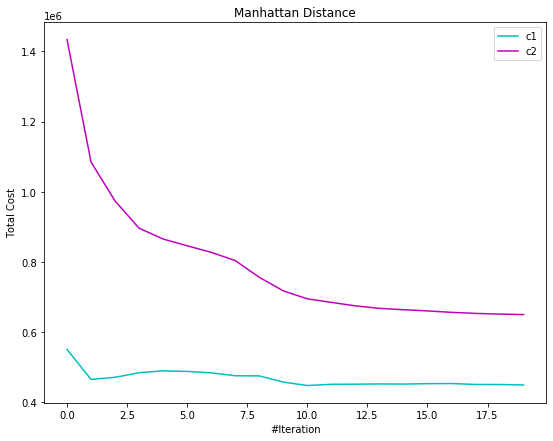

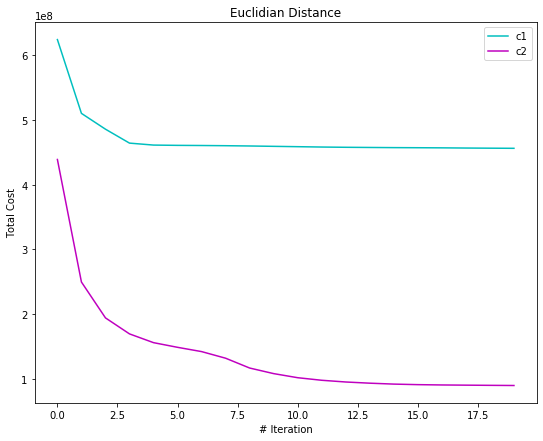

In [ ]:
#@title Plots
from matplotlib import style
style.use('_classic_test_patch')

pl.close('all')
with open('Manhattan_c1.txt', 'rb') as fh:
    l1c1 = pickle.load(fh)
with open('Manhattan_c2.txt', 'rb') as fh:
    l1c2 = pickle.load(fh)
with open('Euclidian_c1.txt', 'rb') as fh:
    l22c1 = pickle.load(fh)
with open('Euclidian_c2.txt', 'rb') as fh:
    l22c2 = pickle.load(fh)

pl.figure(figsize=(9, 7))
pl.title("Manhattan Distance")
pl.plot(l1c1, label='c1',color='c')
pl.plot(l1c2, label='c2',color='m')
pl.xlabel("#Iteration")

pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotManhattan.png', dpi=300)

pl.figure(figsize=(9, 7))
pl.title("Euclidian Distance")
pl.plot(l22c1, label='c1',color='c')
pl.plot(l22c2, label='c2',color='m')
pl.xlabel("# Iteration")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotEuclidian.png', dpi=300)

def change(L):
    return (L[0] - L[10]) / L[0]

print('Euclidian c1', change(l22c1))
print('Euclidian c2', change(l22c2))
print('Manhattan c1', change(l1c1))
print('Manhattan c2', change(l1c2))